(censored_data)=
# Censored Data Models

:::{post} May, 2022
:tags: censored, survival analysis 
:category: intermediate, how-to
:author: Luis Mario Domenzain
:::

In [1]:
from copy import copy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

from numpy.random import default_rng

In [2]:
%config InlineBackend.figure_format = 'retina'
rng = default_rng(1234)
az.style.use("arviz-darkgrid")

[This example notebook on Bayesian survival
analysis](http://docs.pymc.io/notebooks/survival_analysis.html) touches on the
point of censored data. _Censoring_ is a form of missing-data problem, in which
observations greater than a certain threshold are clipped down to that
threshold, or observations less than a certain threshold are clipped up to that
threshold, or both. These are called right, left and interval censoring,
respectively. In this example notebook we consider interval censoring.

Censored data arises in many modelling problems. Two common examples are:

1. _Survival analysis:_ when studying the effect of a certain medical treatment
   on survival times, it is impossible to prolong the study until all subjects
   have died. At the end of the study, the only data collected for many patients
   is that they were still alive for a time period $T$ after the treatment was
   administered: in reality, their true survival times are greater than $T$.

2. _Sensor saturation:_ a sensor might have a limited range and the upper and
   lower limits would simply be the highest and lowest values a sensor can
   report. For instance, many mercury thermometers only report a very narrow
   range of temperatures.

This example notebook presents two different ways of dealing with censored data
in PyMC3:

1. An imputed censored model, which represents censored data as parameters and
   makes up plausible values for all censored values. As a result of this
   imputation, this model is capable of generating plausible sets of made-up
   values that would have been censored. Each censored element introduces a
   random variable.

2. An unimputed censored model, where the censored data are integrated out and
   accounted for only through the log-likelihood. This method deals more
   adequately with large amounts of censored data and converges more quickly.

To establish a baseline we compare to an uncensored model of the uncensored
data.

In [3]:
# Produce normally distributed samples
size = 500
true_mu = 13.0
true_sigma = 5.0
samples = rng.normal(true_mu, true_sigma, size)

# Set censoring limits
low = 3.0
high = 16.0


def censor(x, low, high):
    x = copy(x)
    x[x <= low] = low
    x[x >= high] = high
    return x


# Censor samples
censored = censor(samples, low, high)

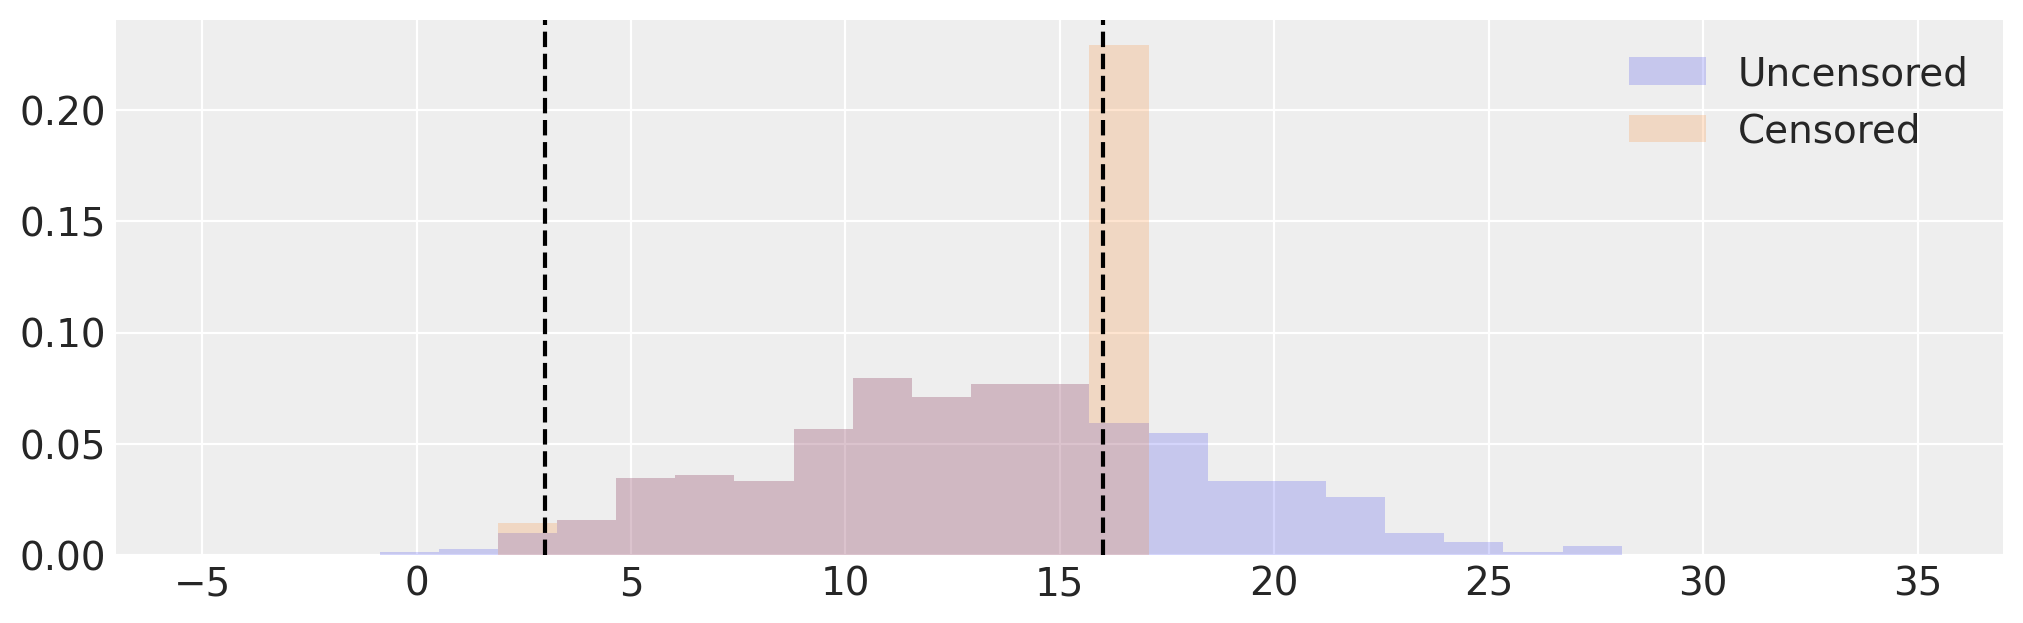

In [4]:
# Visualize uncensored and censored data
_, ax = plt.subplots(figsize=(10, 3))
edges = np.linspace(-5, 35, 30)
ax.hist(samples, bins=edges, density=True, histtype="stepfilled", alpha=0.2, label="Uncensored")
ax.hist(censored, bins=edges, density=True, histtype="stepfilled", alpha=0.2, label="Censored")
[ax.axvline(x=x, c="k", ls="--") for x in [low, high]]
ax.legend();

## Uncensored Model

In [5]:
def uncensored_model(data):
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=((high - low) / 2) + low, sigma=(high - low))
        sigma = pm.HalfNormal("sigma", sigma=(high - low) / 2.0)
        observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=data)
    return model

We should predict that running the uncensored model on uncensored data, we will get reasonable estimates of the mean and variance.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


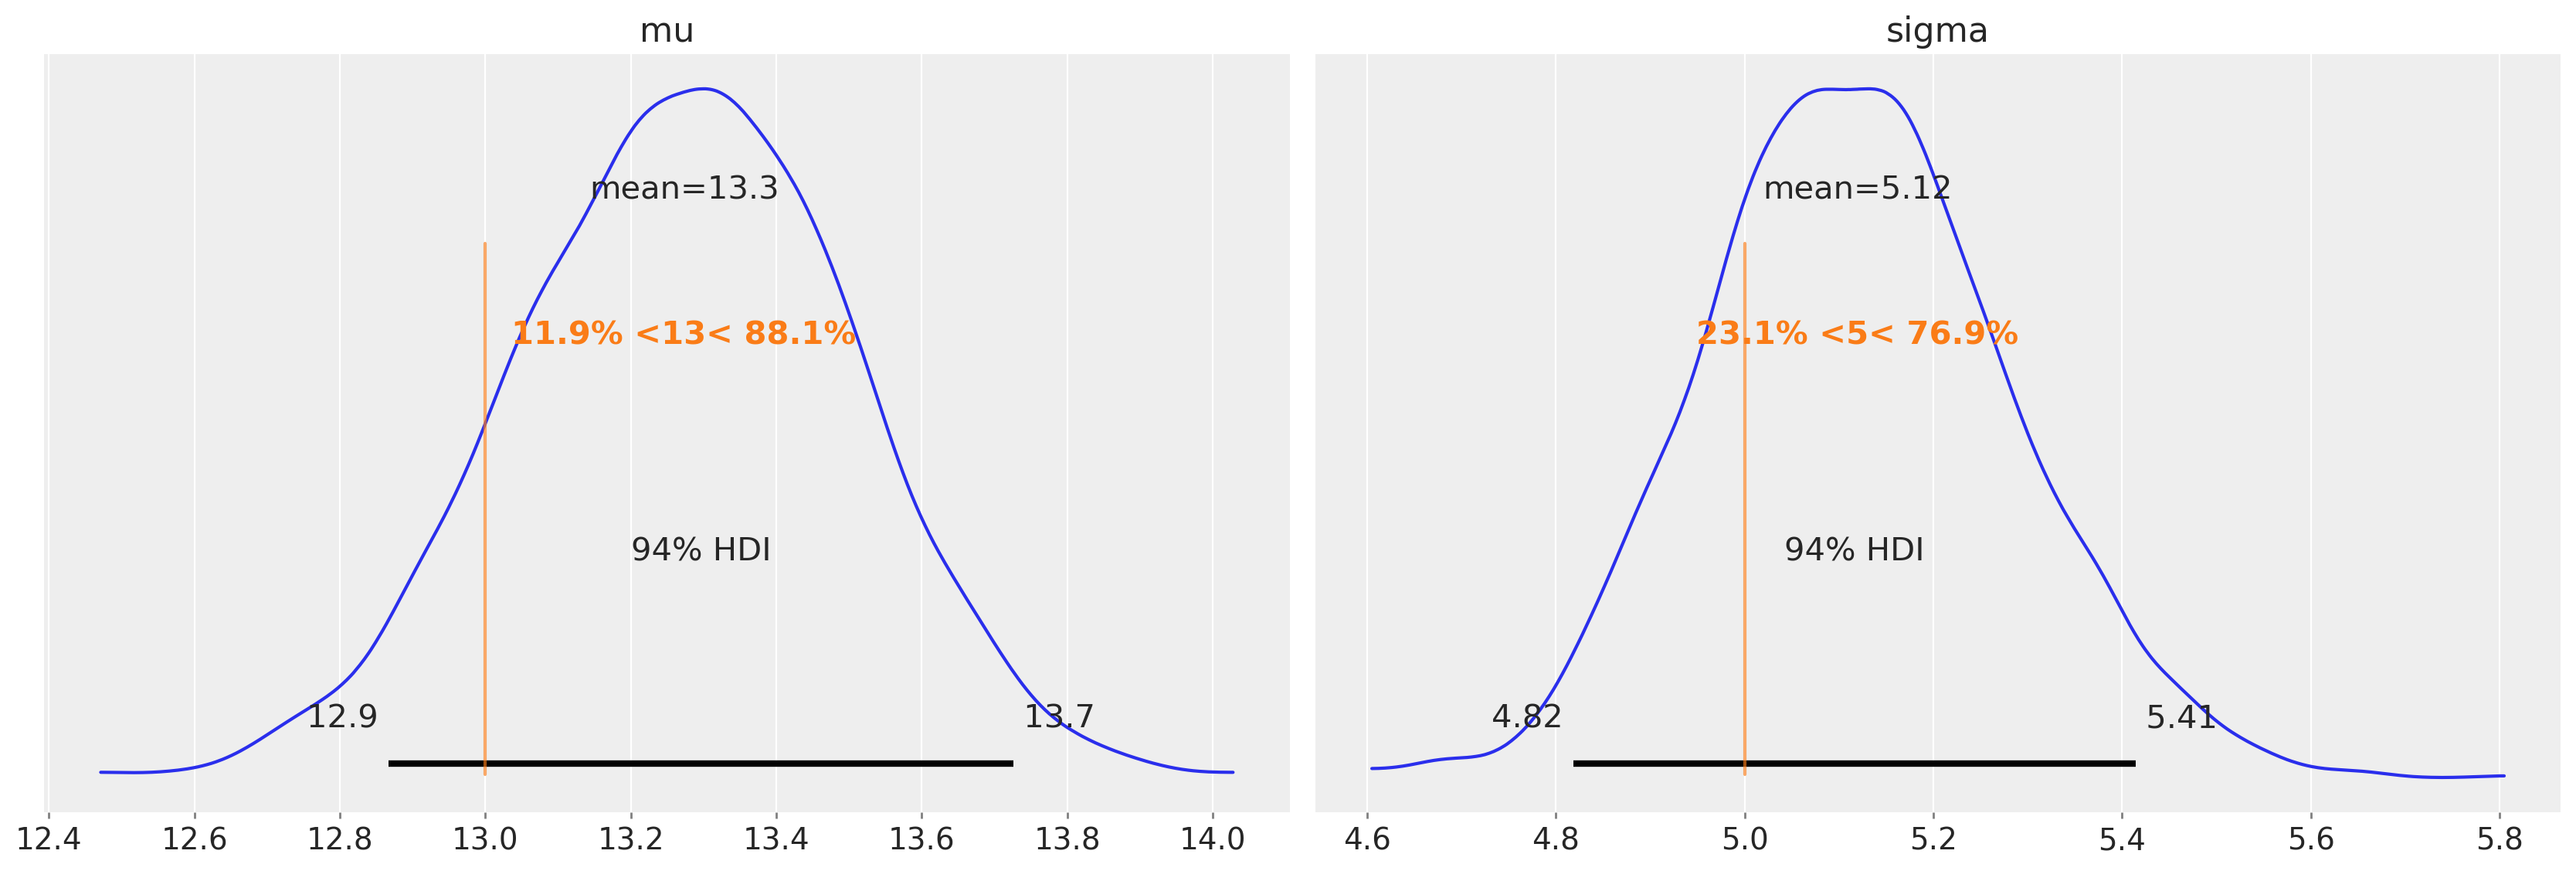

In [6]:
uncensored_model_1 = uncensored_model(samples)
with uncensored_model_1:
    idata = pm.sample()

az.plot_posterior(idata, ref_val=[true_mu, true_sigma], round_to=3);

And that is exactly what we find. 

The problem however, is that in censored data contexts, we do not have access to the true values. If we were to use the same uncensored model on the censored data, we would anticipate that our parameter estimates will be biased. If we calculate point estimates for the mean and std, then we can see that we are likely to underestimate the mean and std for this particular dataset and censor bounds.

In [7]:
print(f"mean={np.mean(censored):.2f}; std={np.std(censored):.2f}")

mean=12.32; std=3.76


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


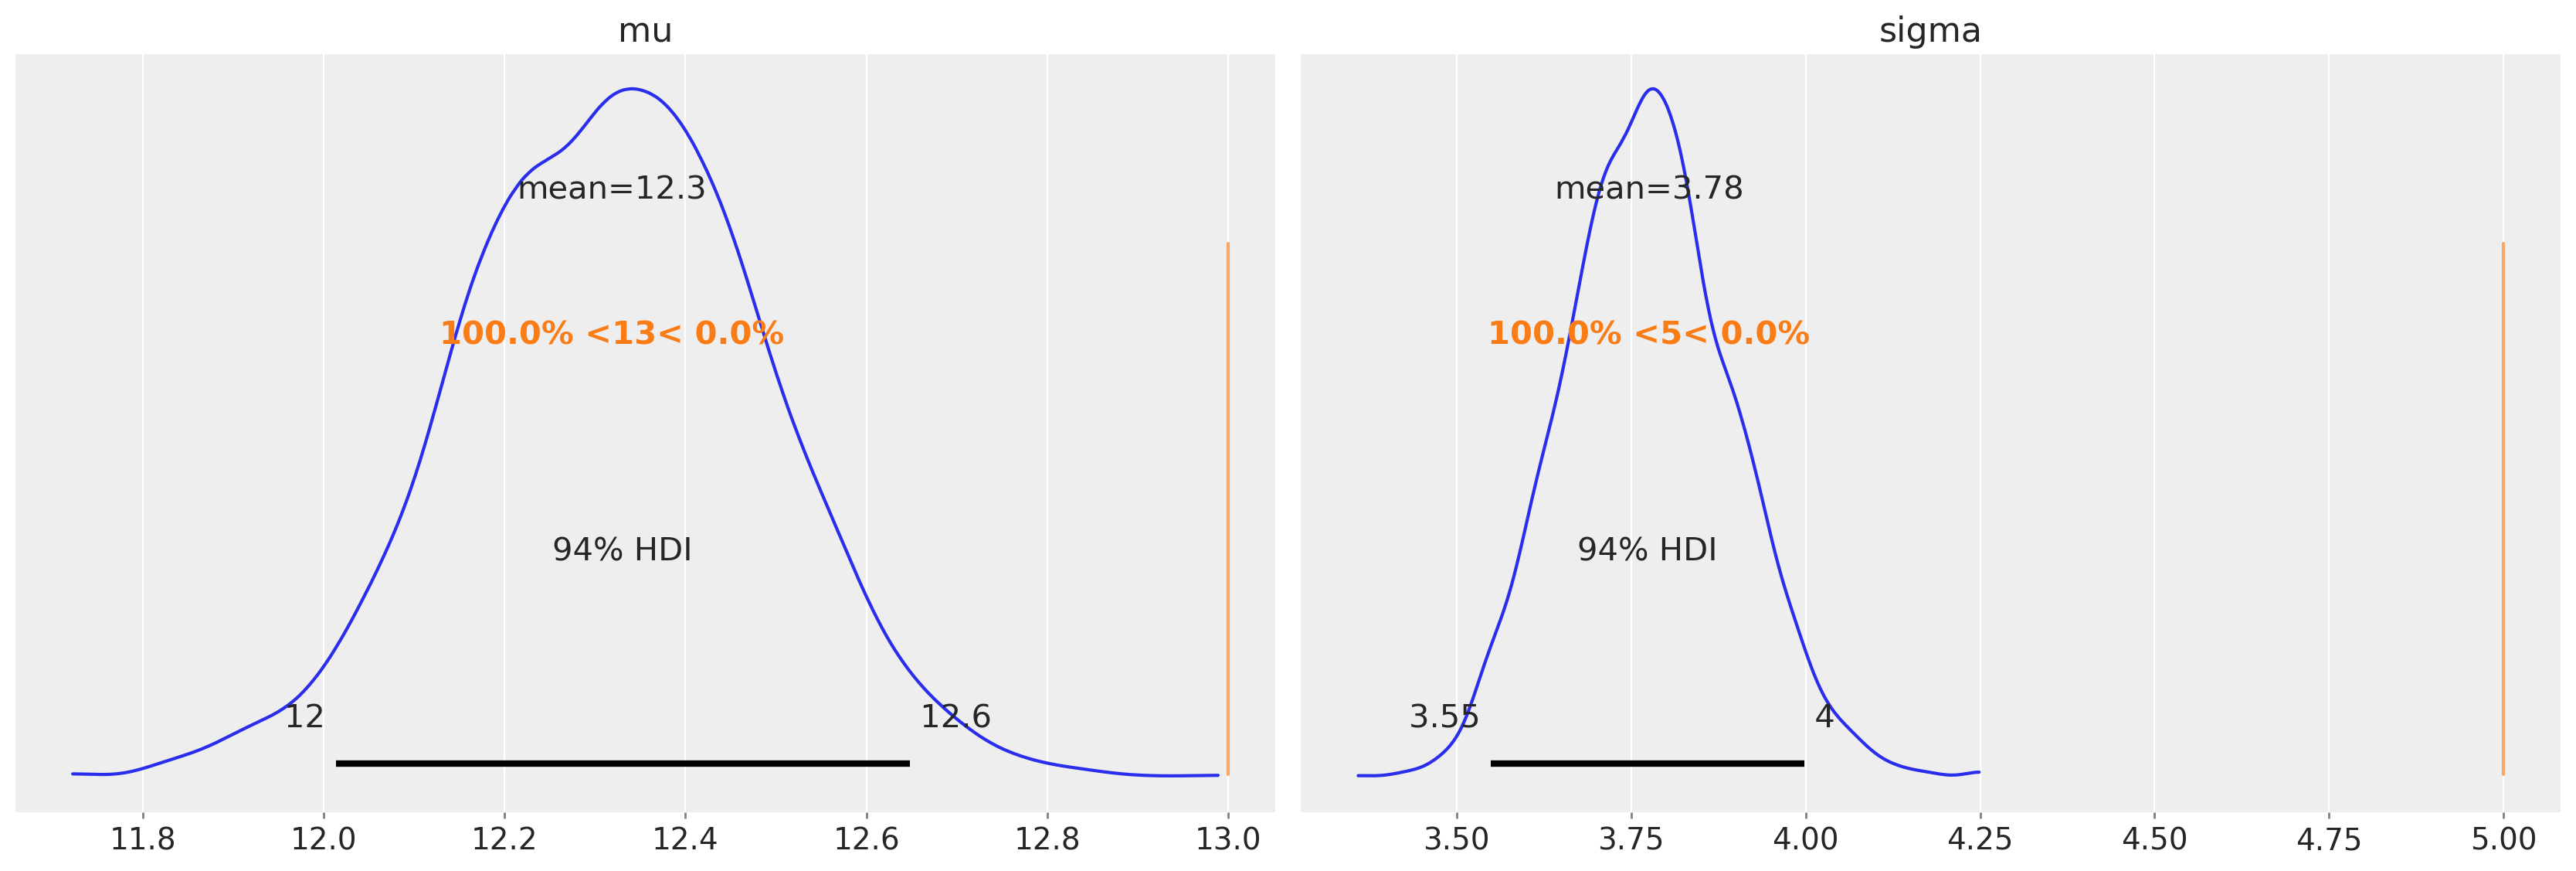

In [8]:
uncensored_model_2 = uncensored_model(censored)
with uncensored_model_2:
    idata = pm.sample()

az.plot_posterior(idata, ref_val=[true_mu, true_sigma], round_to=3);

The figure above confirms this.

## Censored data models

The models below show 2 approaches to dealing with censored data. First, we need to do a bit of data pre-processing to count the number of observations that are left or right censored. We also also need to extract just the non-censored data that we observe.

(censored_data/model1)=
### Model 1 - Imputed Censored Model of Censored Data

In this model, we impute the censored values from the same distribution as the uncensored data. Sampling from the posterior generates possible uncensored data sets.

In [9]:
n_right_censored = sum(censored >= high)
n_left_censored = sum(censored <= low)
n_observed = len(censored) - n_right_censored - n_left_censored
uncensored = censored[(censored > low) & (censored < high)]
assert len(uncensored) == n_observed

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, right_censored, left_censored]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


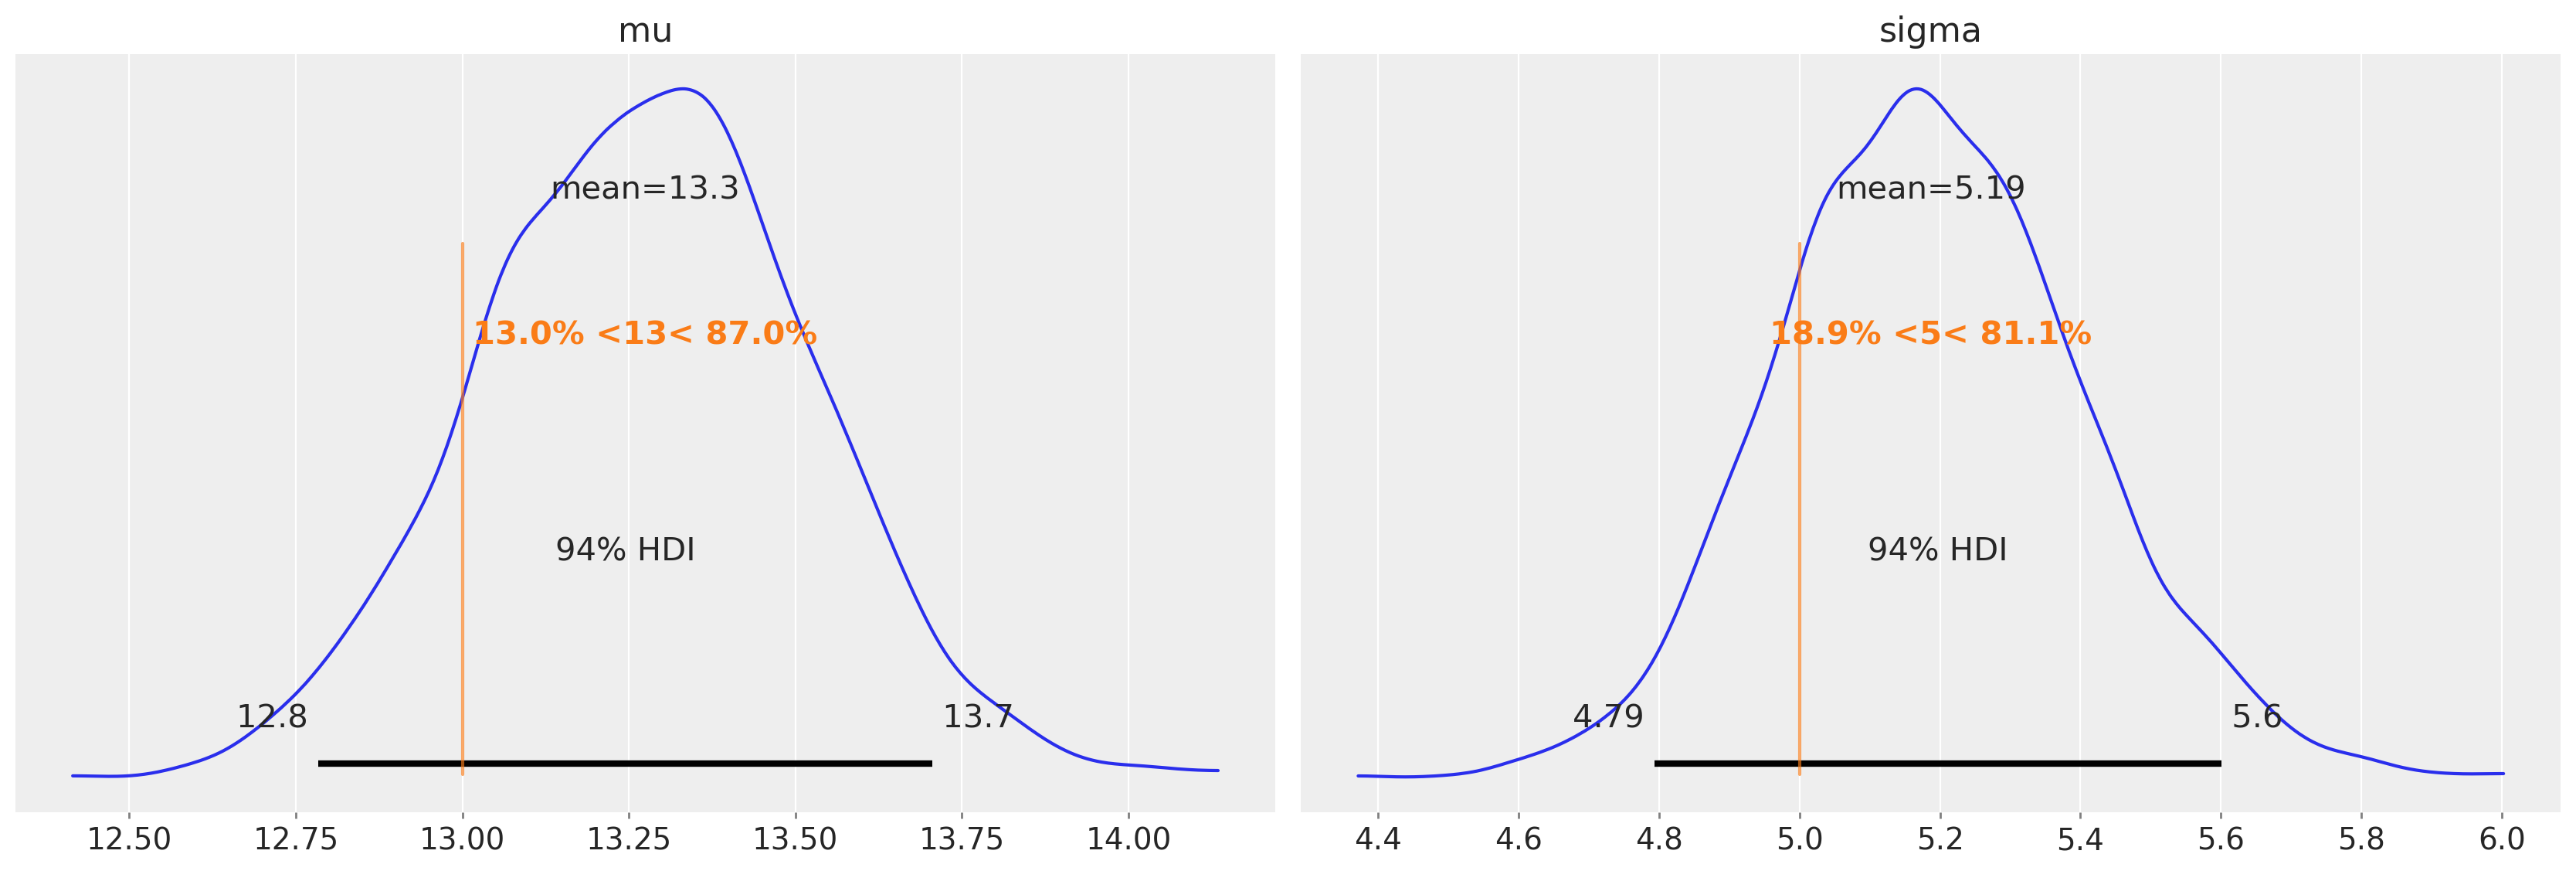

In [10]:
with pm.Model() as imputed_censored_model:
    mu = pm.Normal("mu", mu=((high - low) / 2) + low, sigma=(high - low))
    sigma = pm.HalfNormal("sigma", sigma=(high - low) / 2.0)
    right_censored = pm.Normal(
        "right_censored",
        mu,
        sigma,
        transform=pm.distributions.transforms.Interval(high, None),
        shape=int(n_right_censored),
        initval=np.full(n_right_censored, high + 1),
    )
    left_censored = pm.Normal(
        "left_censored",
        mu,
        sigma,
        transform=pm.distributions.transforms.Interval(None, low),
        shape=int(n_left_censored),
        initval=np.full(n_left_censored, low - 1),
    )
    observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=uncensored, shape=int(n_observed))
    idata = pm.sample()

az.plot_posterior(idata, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma], round_to=3);

We can see that the bias in the estimates of the mean and variance (present in the uncensored model) have been largely removed.

### Model 2 - Unimputed Censored Model of Censored Data

Here we can make use of `pm.Censored`.

In [11]:
with pm.Model() as unimputed_censored_model:
    mu = pm.Normal("mu", mu=0.0, sigma=(high - low) / 2.0)
    sigma = pm.HalfNormal("sigma", sigma=(high - low) / 2.0)
    y_latent = pm.Normal.dist(mu=mu, sigma=sigma)
    obs = pm.Censored("obs", y_latent, lower=low, upper=high, observed=censored)

Sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


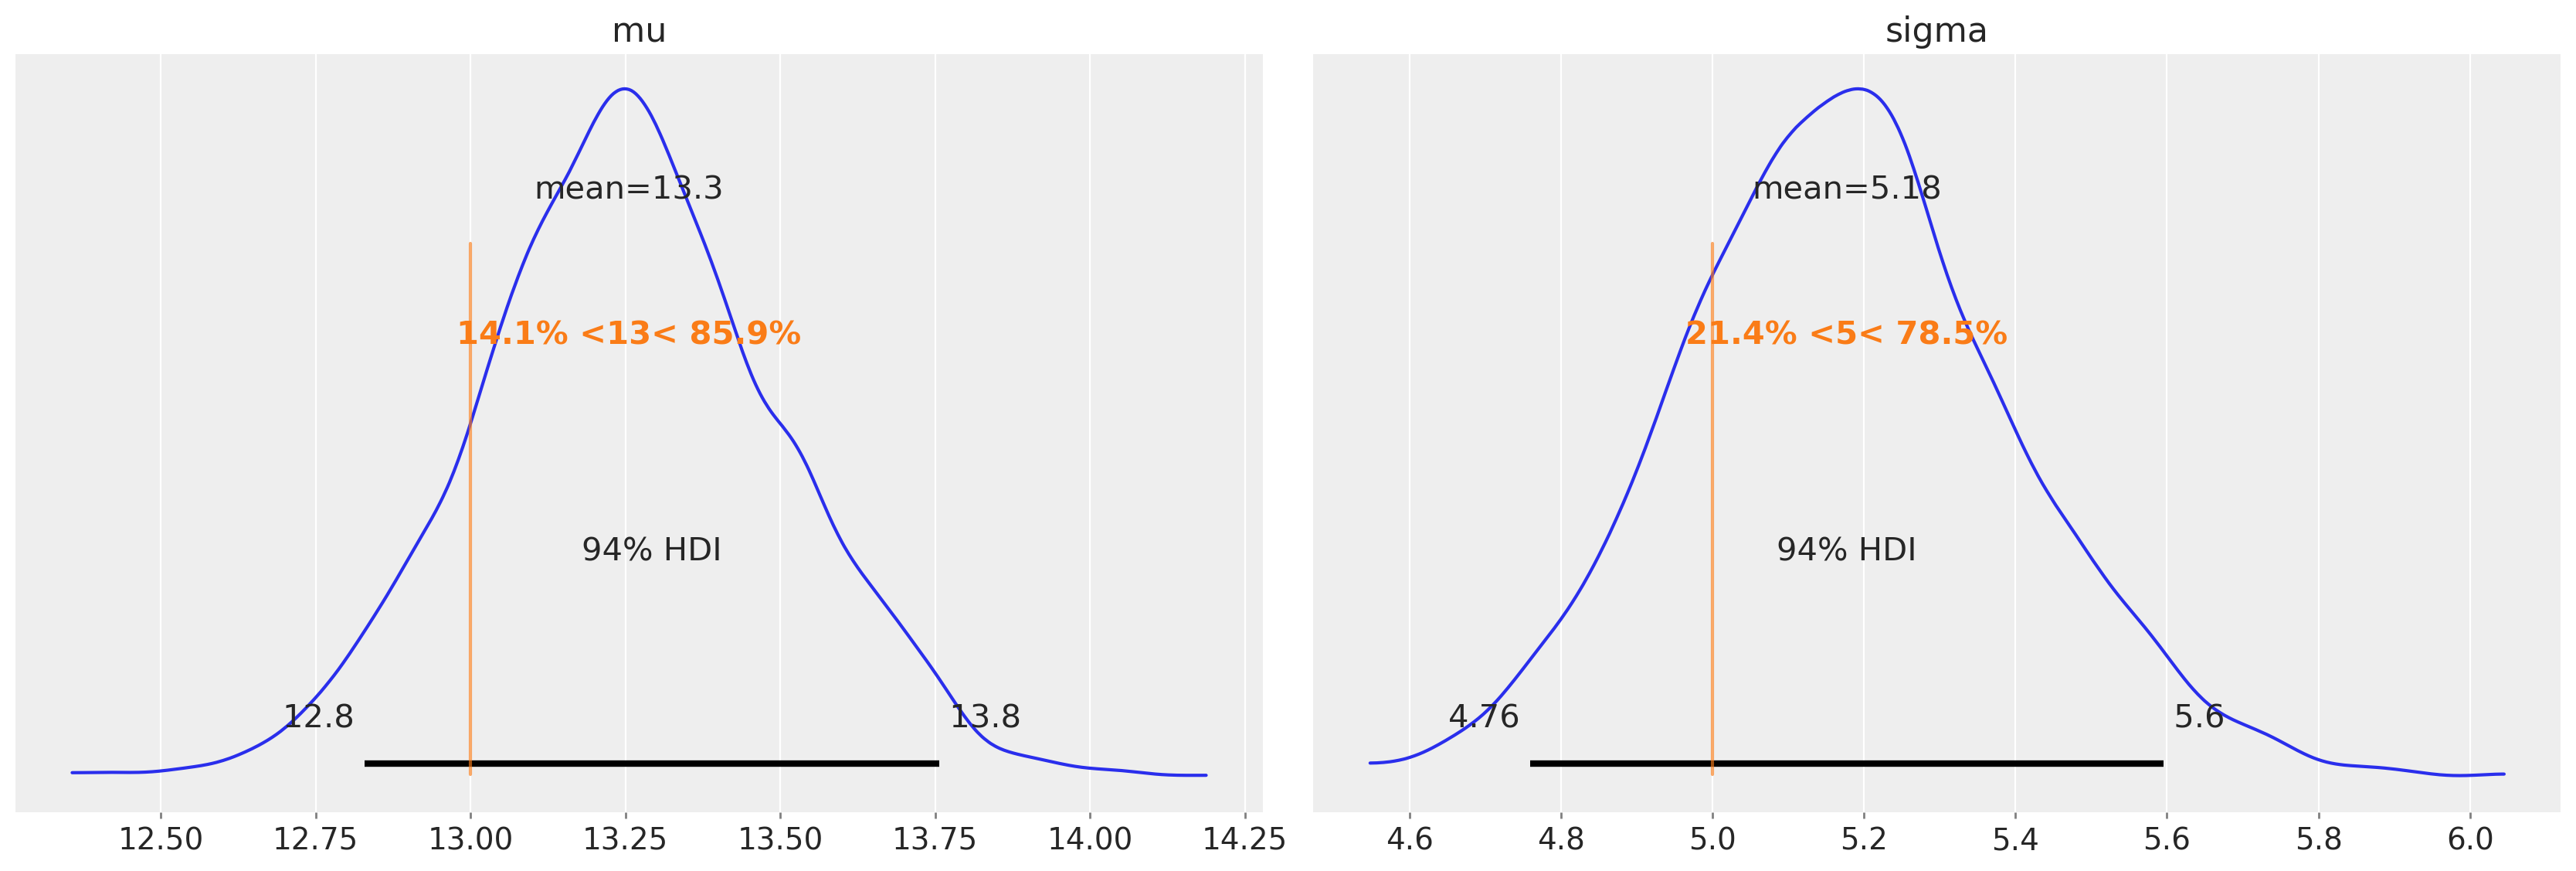

In [12]:
with unimputed_censored_model:
    idata = pm.sample()

az.plot_posterior(idata, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma], round_to=3);

Again, the bias in the estimates of the mean and variance (present in the uncensored model) have been largely removed.

## Discussion

As we can see, both censored models appear to capture the mean and variance of the underlying distribution as well as the uncensored model! In addition, the imputed censored model is capable of generating data sets of censored values (sample from the posteriors of `left_censored` and `right_censored` to generate them), while the unimputed censored model scales much better with more censored data, and converges faster.

## Authors

- Originally authored by [Luis Mario Domenzain](https://github.com/domenzain) on Mar 7, 2017.
- Updated by [George Ho](https://github.com/eigenfoo) on Jul 14, 2018.
- Updated by [Benjamin Vincent](https://github.com/drbenvincent) in May 2021.
- Updated by [Benjamin Vincent](https://github.com/drbenvincent) in May 2022 to PyMC v4.

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl

Last updated: Tue Jan 17 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

pytensor: 2.9.1
aeppl   : not installed

seaborn   : 0.12.2
pymc      : 5.0.1+42.g99dd7158
arviz     : 0.14.0
matplotlib: 3.6.2
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
numpy     : 1.24.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::